# Homework 7 (50 points)

In this Homework, we will try to classify observations of space to be either stars, galaxies or quasars based on the RD14 from the Sloan Digital Sky Survey  (SDSS). The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested. 

http://www.sdss.org/
![alt text](http://www.fingerprintdigitalmedia.com/wp-content/uploads/2014/08/sdss1.jpg)

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.


In this homework we will train several classifier to predict the class of a celestial object based on the observations (features). We will practice data prep, dimensionality reduction, model design and training, model comparison, and feature importance selection.

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter as Ct
import time
import sklearn.decomposition
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline


## 1) Data Preparation (20 points)

We follow the following steps:
* read (1 point)
* clean (3 points)
* correlate (4 points)
* explore, spread of values (3 points)
* dimensionality reduction (9 points)

### 1.1 Data read
Read the pandas fata frame from the csv file "Skyserver_SQL2_27_2018.csv" and skip the first row.

**Task: read (1 point)**

Save a copy of the data frame just in case.

In [2]:
# answer
data_frame = pd.read_csv("./Skyserver_SQL2_27_2018.csv")

data_frame

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.237650e+18,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,1345,301,3,161,5.033450e+17,GALAXY,0.027583,447,51877,246
9996,1.237650e+18,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,1345,301,3,162,5.033400e+17,GALAXY,0.117772,447,51877,228
9997,1.237650e+18,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,1345,301,3,162,8.222620e+18,STAR,-0.000402,7303,57013,622
9998,1.237650e+18,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,1345,301,3,163,5.033400e+17,GALAXY,0.014019,447,51877,229


**Description of the data fields**

* objid = Object Identifier, self explanatory.
* ra = J2000 Right Ascension (r-band). Angular that is measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question.   https://en.wikipedia.org/wiki/Right_ascension
* dec = J2000 Declination (r-band). Angle that is measured north or south of the celestial equator, along the hour circle passing through the point in question. https://en.wikipedia.org/wiki/Declination



The Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

Further Information: http://astroweb.case.edu/ssm/ASTR620/mags.html 
* u = better of DeV/Exp magnitude fit
* g = better of DeV/Exp magnitude fit
* r = better of DeV/Exp magnitude fit
* i = better of DeV/Exp magnitude fit
* z = better of DeV/Exp magnitude fit




Run, rerun, camcol and field are features which describe a field within an image taken by the SDSS. A field is basically a part of the entire image corresponding to 2048 by 1489 pixels. 
* run = Run Number, which identifies the specific scan. 
* rereun = Rerun Number, which specifies how the image was processed.
* camcol = Camera column, a number from 1 to 6, identifying the scanline within the run.
* field = Field number, which typically starts at 11 (after an initial rampup time), and can be as large as 800 for particularly long runs.
* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object): The class identifies an object to be either a galaxy, star or quasar. This will be the response variable which we will be trying to predict.

* redshift = Final Redshift: In physics, **redshift** happens when light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum. 

* plate = plate number: Each spectroscopic exposure employs a large, thin, circular metal **plate** that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number, which is called plate in views such as SpecObj in the CAS.

* mjd = MJD of observation, **Modified Julian Date**, used to indicate the date that a given piece of SDSS data (image or spectrum) was taken.
* fiberid = fiber ID. The SDSS spectrograph uses optical fibers to direct the light at the focal plane from individual objects to the slithead. Each object is assigned a corresponding **fiberID**. 

**Further information on SDSS images and their attributes:** 

http://www.sdss3.org/dr9/imaging/imaging_basics.php

http://www.sdss3.org/dr8/glossary.php

### 1.2 Data Cleaning 

Basic stats about our dataset. 

**Task: Provide basic infor for the pandas dataframe head (0.5 point)**

In [3]:
# head
data_frame.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


**Task: Find the data types of the database (floats, string, etc etc) using the ``info()`` function (0.5 point).**

In [4]:
# information
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


Are there any obvious feature (or element of the dataframe) that should not impact our prediction?
 
**objid** and **specobjid** are just identifiers for accessing the rows back when they were stored in the original databank. Therefore we will not need them for classification as they are not related to the outcome.
The features **run**, **rerun**, **camcol** and **field** are values which describe parts of the camera at the moment when making the observation, e.g. 'run' represents the corresponding scan which captured the oject.

Source: http://www.sdss3.org/dr9/imaging/imaging_basics.php

**Task: Drop these columns in the pandas dataframe. (1 point)**

In [5]:
# answer
data_frame.drop(columns = ['objid', 'specobjid', 'run', 'rerun', 'camcol', 'field'], inplace = True)


Find our how many examples there are, how many attributes or feature, and the type of class.

In [6]:
# description
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ra        10000 non-null  float64
 1   dec       10000 non-null  float64
 2   u         10000 non-null  float64
 3   g         10000 non-null  float64
 4   r         10000 non-null  float64
 5   i         10000 non-null  float64
 6   z         10000 non-null  float64
 7   class     10000 non-null  object 
 8   redshift  10000 non-null  float64
 9   plate     10000 non-null  int64  
 10  mjd       10000 non-null  int64  
 11  fiberid   10000 non-null  int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 937.6+ KB


**Task: How many objects are in each class? (1 point)**

In [7]:
# Count the elements in each class
Ct(data_frame['class'])

Counter({'STAR': 4152, 'GALAXY': 4998, 'QSO': 850})

The classes are "GALAXY", "STAR", and "QSO" (quasars). They are defined as strings, but we will convert them to integer in order to apply a loss function on the class labels during training. For this, we use the ``sklearn.preprocessing.LabelEncoder()`` function. We will do so and modify the classes in the dataframe. We should keep a copy of the original data frame to be safe.

In [8]:
sdss_df_save = data_frame # make a copy of the original data before cleaning it. That works well when the data is small.

# encode class labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(data_frame['class'])
data_frame['class'] = y_encoded
Ct(data_frame['class'])
#  GALAXY = 0
# STAR = 1
# QSO = 2

Counter({2: 4152, 0: 4998, 1: 850})

### 1.3 Data correlations
Now let's find the most basic correlations among features. This can be done using the ``corr()`` function to apply on the pandas dataframe. Evaluate this function and comment on what feature is correlated among others. It is convenient to use the matplotlib function ``matshow()`` for clarity. ``seaborn`` is a python module that makes really pretty statistical plots https://seaborn.pydata.org/index.html#. Install it with ``pip`` and import it.

In [9]:
import seaborn as sns

**Task: Plot the correlation matrix that can be called in the pandas dataframe. (2 points)**

Hints:

Use functions of ``heatmap``, add the labels in the axes. The colormap ``coolwarm`` is nice for divergent scales like correlations that vary between -1 and 1. The argument ``center=0`` ensures that the colormap is divergent from zero. Make sure to ignore the label column "class". Remember that dropping a column can be done in place ``sdss_df.drop('class', axis=1)``.

<AxesSubplot: >

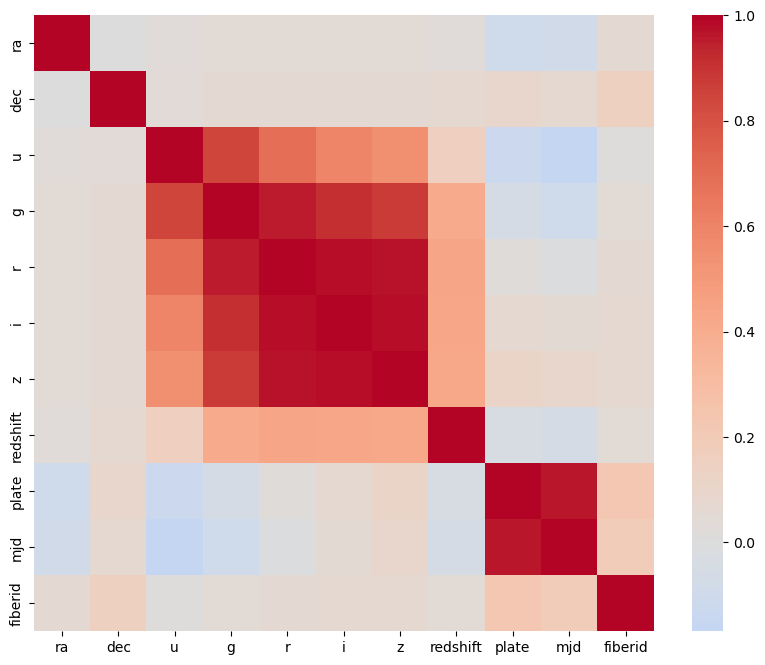

In [10]:
# answer
plt.figure(figsize = (10,8))
sns.heatmap(data_frame.drop('class', axis=1).corr(), cmap = 'coolwarm', center = 0)

**Task: Reproduce the same plot for each of the three classes. (1 point)**
You can select the values from the pandas dataframe by selecting over the column 'class'. 

Text(0.5, 1.0, 'Quasars')

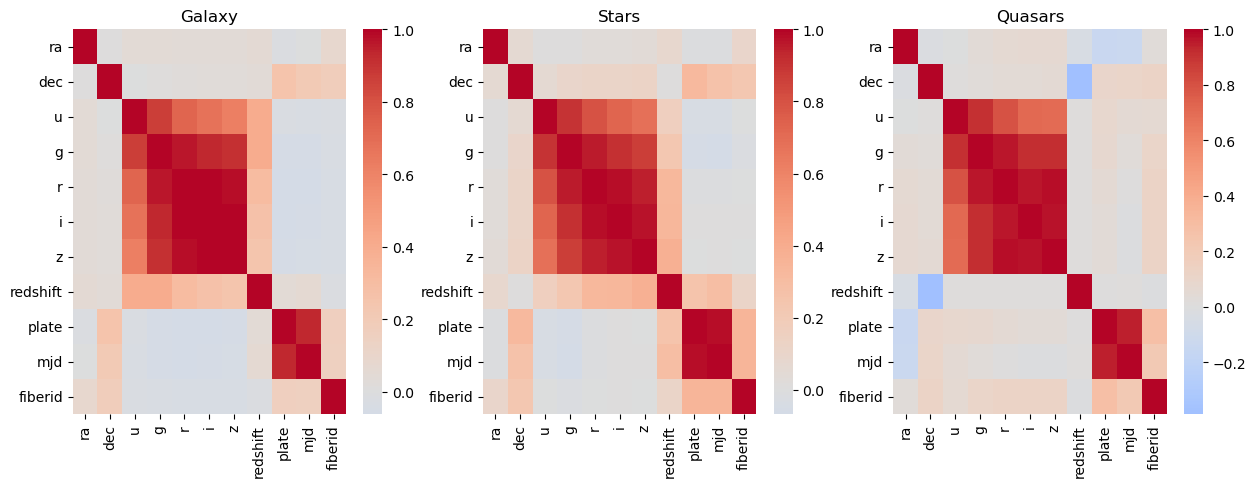

In [11]:
# make the same plot for Galaxies
# "GALAXY" is label 0
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
sns.heatmap(data_frame[data_frame['class']==0].drop('class', axis=1).corr(), cmap = 'coolwarm', center = 0)
plt.title('Galaxy')
# Make the same plot for Stars (label 1)
plt.subplot(1,3,2)
sns.heatmap(data_frame[data_frame['class']==1].drop('class', axis=1).corr(), cmap = 'coolwarm', center = 0)
plt.title('Stars')
# make the same plots for quasars (label 2)
plt.subplot(1,3,3)
sns.heatmap(data_frame[data_frame['class']==2].drop('class', axis=1).corr(), cmap = 'coolwarm', center = 0)
plt.title('Quasars')

**Task: Can you comment on groups of observations that can be grouped together or that appear independent from each other given these correlations, and if there is any difference between the three celestial objects? (**1 point**)**

Looking at the central red square in all 3 plots, seems like u,g,r,i,and z can be grouped together because theres high correlation for the 3 classes. There are clear differences in correlations in all 3 classes for dec and redshift 

### 1.5 Data exploration
Given the structure of the correlations, we will explore the values of the data.

#### 1.5.a. Distributions of redshift
"redshifting" happens when the source of light is becoming more distant to the receiver: the object is moving away from Earth. 

**Task: plot histograms for the 'redshift' feature column for each class (1 point).**

Text(0.5, 1.0, 'STAR')

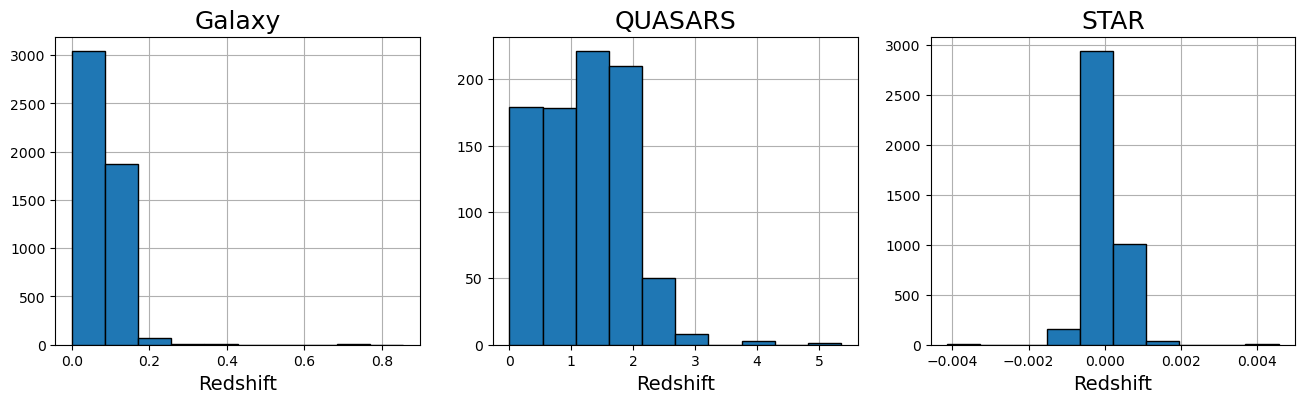

In [12]:
# answer

plt.figure(figsize = (16,4))


plt.subplot(1, 3, 1)
# "GALAXY" is label 0
plt.hist(data_frame[data_frame['class']==0]['redshift'], edgecolor = 'k', zorder = 90)
plt.xlabel("Redshift", fontsize = 14)
plt.grid(True)
plt.title('Galaxy', fontsize = 18)

plt.subplot(1, 3, 2)
plt.hist(data_frame[data_frame['class']==1]['redshift'], edgecolor = 'k', zorder = 90)
plt.xlabel("Redshift", fontsize = 14)
plt.grid(True)
plt.title('QUASARS', fontsize = 18)

plt.subplot(1, 3, 3)
plt.hist(data_frame[data_frame['class']==2]['redshift'], edgecolor = 'k', zorder = 90)
plt.xlabel("Redshift", fontsize = 14)
plt.grid(True)
plt.title('STAR', fontsize = 18)

**Task : Describe briefly the difference between the three histograms. (0.5 point)**

<!-- # answer -->
* **Star:** The histogram looks like a truncated zero-centered normal distribution. It looks like stars are both coming toward and away from the Earth.

* **Galaxy:** The redshift values may come from a slightly right-shifted normal distribution which is centered around 0.075. It looks like galaxies are moving away from the Earth but at slow speeds.

* **QSO:** The redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed from 0 to 3, than the occurences decrease drastically. For 4 oder ~5.5 there are some outliers. This probably means that quasards are moving away from the earth with a diverse range of speeds.


#### 1.5.b. Right ascension (ra) and declination (dec) 

We will now plot the right ascension versus the declination depending on the class. You can use the ``lmplot`` function in ``seaborn`` (https://seaborn.pydata.org/generated/seaborn.lmplot.html) to represent the sky view of these objects.

Text(0.5, 1.0, 'Equatorial coordinates')

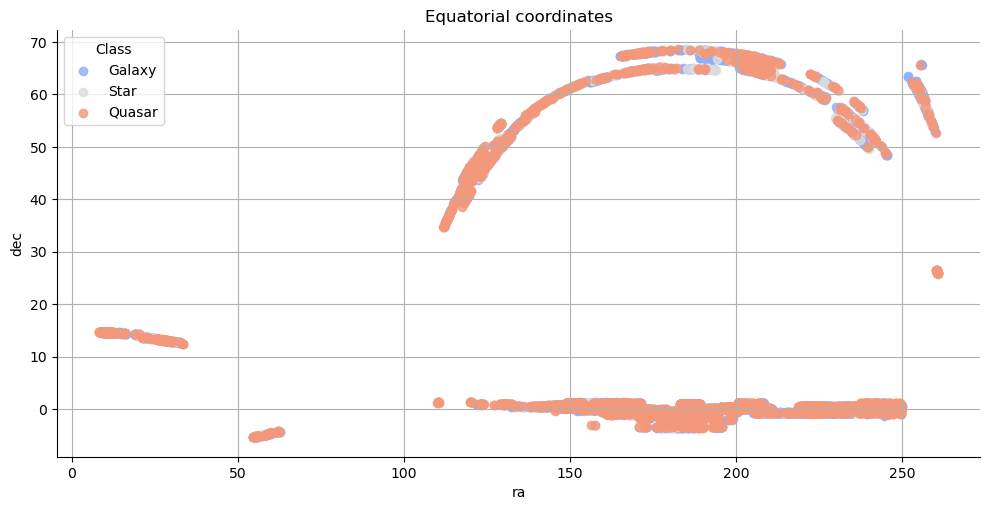

In [13]:
sns.lmplot(x='ra', y='dec', data=data_frame, hue='class', fit_reg=False, palette='coolwarm', aspect=2,legend=False)
plt.legend(title='Class', loc='upper left', labels=['Galaxy', 'Star','Quasar'])
plt.grid(True)
plt.title('Equatorial coordinates')

**Task: do you see any obvious differences such that one could easily discriminate between the two coordinates? (0.5 point)**

### No

#### 1.5.c Filters - u,g,r,i,z 

Recall: u, g, r, i, z represent the different wavelengths which are used to capture the observations. According to the correlation matrix, they are correlated for all three classes.

Therefore it is interesting to see that band 'u' is less correlated to the other bands. 

**Task Plot histograms and discuss why you expect these features to be correlated (1 points)**

(12.0, 20.0)

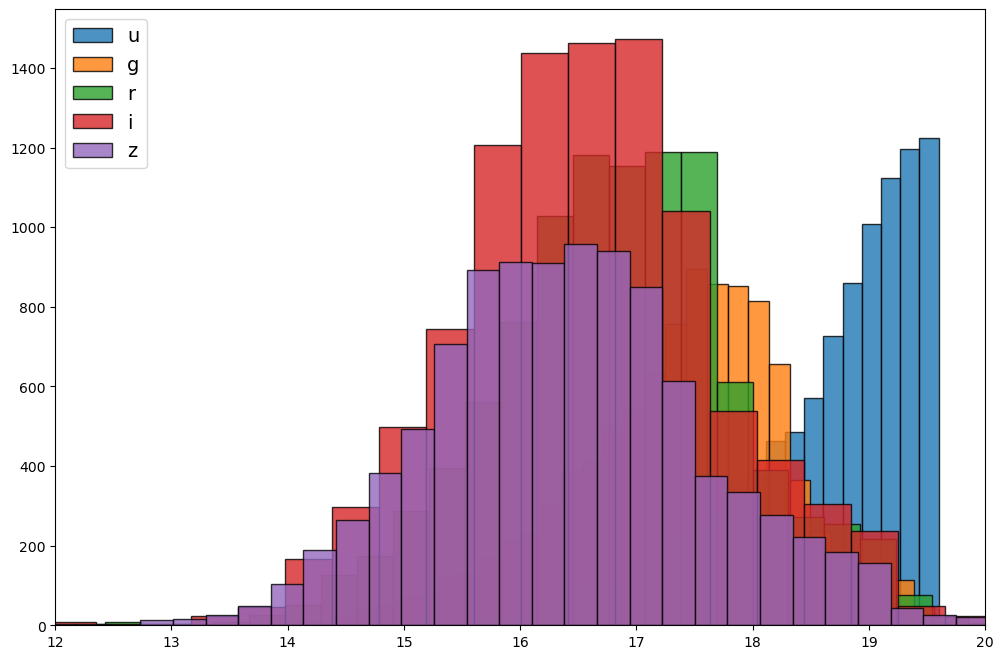

In [14]:
# Plot of histograms
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize = (12, 8))
for c in ['u', 'g', 'r', 'i', 'z']:
    plt.hist(data_frame[c], 40, edgecolor = 'k', alpha = 0.8, label = c)
plt.legend(fontsize = 14)
plt.xlim([12, 20])

<!-- Anwer: -->
### All of these features are well correlated because there is so much overlap with all of them with the exception of u

### 1.6 Data Dimensionality Reduction
At this point, we are left with 8 features: redshift, u, g, r, i, z, ra, and dec. Among these, the filters (u, g, r, i, z) are correlated to each other. There is therefore a potential for reducing the dimensions of the features using PCA on these 5 features.

We will use the skilearn function ``sklearn.decomposition.PCA()`` to fit and transform the data into the PC coordinates. Lets' first explore how many PCs we need. Fit the PCA function over the total number of filters. You will fit the PCA function over an array with the columns selected from the dataframe. 

**Task: Perform the PCA over a max number of PCs, output the explained variance ratio values, decide on an appropriate maximum number of PC to use (6 points)**

In [15]:
# anwer

X = np.array(data_frame[['u','r','i','z','ra','dec','redshift']])
pca = sklearn.decomposition.PCA()
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)


[7.80970257e-01 2.17420339e-01 1.41057048e-03 1.45173693e-04
 4.09387446e-05 7.65082399e-06 5.07060331e-06]
[4778.12612716 2521.10216981  203.06625392   65.14548539   34.59454497
   14.95527723   12.17503393]


*Answer on how many PCs to use*
### Use 5 PCs to remove single values less than 20


We will now re-perform PCA with the number of PCs you found is most appropriate. Re-apply the fit-transform function. Update the dataframe by adding the PCA value(s) and dropping the columns of the 5 filter features.

**Task: PCA again, fit and transform, update the dataframe with the new feature(s) (3 points)**

In [16]:
# answer
pca = sklearn.decomposition.PCA(n_components = 5)
pca.fit(X)
df = pd.concat([data_frame, pd.DataFrame(pca.transform(X), columns=['PC1', "PC2", "PC3", "PC4", "PC5"])], axis = 1)

In [17]:
# answer
data_frame

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,2,-0.000009,3306,54922,491
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,2,-0.000055,323,51615,541
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0,0.123111,287,52023,513
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,2,-0.000111,3306,54922,510
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,2,0.000590,3306,54922,512
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,0,0.027583,447,51877,246
9996,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,0,0.117772,447,51877,228
9997,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,2,-0.000402,7303,57013,622
9998,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,0,0.014019,447,51877,229


## 2) Machine Learning Models (26 points)

We will now train different models on this dataset. We have a total of 8 features, 3 classes, and 10,000 samples. We will use K-Nearest Neighbors, Naive Bayes, Random Forest, Support Vector Machine, Multi Layer Perceptron.

We now follow a normal machine learning workflow:
* Feature scaling (2 points)
* Train/test set split (2 points)
* Model design, training, testing (15 points)
* Model comparisons, pick your winner, discuss feature importance using Random Forest. (10 points)

### 2.1 Feature Scaling
Scaling all values to be within the (0, 1) interval will reduce the distortion due to exceptionally high values and make some algorithms converge faster. You can scale the features only by dropping the "class" column without modifying the dataframe in place, using the pandas function ``drop()``.

**Task: Scale just the features (2 points)**

In [18]:
# answer
x = np.array(data_frame[['u', 'g', 'r', 'i', 'z', 'ra', 'dec', 'redshift']])
y = np.array(data_frame['class'])
x -= np.min(x, axis = 0)
x /= np.max(x, axis = 0)

### 2.2 Test, train, validation data sets.
**Task: Split the data into a training and a test part.  (2 points)**

The models will be trained on the training data set and tested on the test data set

In [19]:
# answer
idx_train = np.random.choice(np.arange(10000), 8000, replace = False)
idx_test = np.setdiff1d(np.arange(10000), idx_train)

xtrain = x[idx_train, :]
ytrain = y[idx_train]

xtest = x[idx_test, :]
ytest = y[idx_test]

Computation time is important to account for when scaling up the data set and the model size. You can evaluate the relative computational time using the function ``time.perf_counter()`` to evaluate the absolute time. Then compare the computational time by making the difference between two time stamps:

``t1=time.perf_counter()``

``t2=time.perf_counter()``

``tcomp = t2 - t1``

We will also assess the model performance of these multi-class classifiers. We will evaluate the average of the scores over the 3 class labels.

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_predict
label_name = ['Star','Galaxy','Quasar']

In the following, we will be testing over several classifiers. Follow the steps:
1. model definition/design
2. training
3. prediction on test
4. evaluation: a) print the classification_report; b) save the precision, recall, fscore and accuracy in variables

### 2.3.a K Nearest Neighbors (3 points)
Check out the function arguments and definition here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [22]:
#answer
from sklearn.neighbors import KNeighborsClassifier
print("Classifying using K-nearest Neighbors")

t1 = time.perf_counter()
# model design
KN = KNeighborsClassifier()

# training
KN.fit(xtrain, ytrain)

t2 = time.perf_counter()
tcompKNC = t2 - t1
print(tcompKNC)

# evaluation on test
ypredict = KN.predict(xtest)

# print the classification report
# save values of precision, recall, fscore, accuracy.
print(classification_report(ytest, ypredict))

Classifying using K-nearest Neighbors
0.010033538099378347
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1005
           1       0.96      0.93      0.95       163
           2       0.84      0.89      0.86       832

    accuracy                           0.88      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.88      0.88      0.88      2000



### 2.3.b Naive Bayes (3 points)
Check out the sklearn tutorial pages here: https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes. We propose to use the Gaussian Naive Bayes.

Naive Bayes assumes the data to be normally distributed which can be achieved by scaling using the MaxAbsScaler. For this example then we will use the unscaled data, then rescale it.

In [23]:
# answer
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MaxAbsScaler
print("Classifying using Gaussian Naive Bayes")


t1 = time.perf_counter()
# model design
scaler = MaxAbsScaler()
gnb = GaussianNB()


# re-scale the data
sdss = scaler.fit_transform(data_frame[['u', 'g', 'r', 'i', 'z', 'ra', 'dec', 'redshift']])

xtrain = x[idx_train, :]
ytrain = y[idx_train]

xtest = x[idx_test, :]
ytest = y[idx_test]


# training
gnb.fit(xtrain, ytrain)


# evaluation
t2 = time.perf_counter()
tcompNB = t2-t1
print(tcompNB)

ypredict = gnb.predict(xtest)
# evaluation: 
# print the classification report
# save values of precision, recall, fscore, accuracy.
print(classification_report(ytest, ypredict))

Classifying using Gaussian Naive Bayes
0.008646874688565731
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1005
           1       0.86      0.94      0.90       163
           2       1.00      0.98      0.99       832

    accuracy                           0.98      2000
   macro avg       0.95      0.97      0.96      2000
weighted avg       0.98      0.98      0.98      2000



### 2.3.c Random Forest Classifier (2 points)
Check out the tutorial page here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [24]:
# answer
from sklearn.ensemble import RandomForestClassifier
print("Classifying using Random Forest Classifiers")


# model design
t1 = time.perf_counter()
RandF = RandomForestClassifier()

# training
RandF.fit(xtrain, ytrain)

t2 = time.perf_counter()
tcompRandF = t2 -t1
print(tcompRandF)

# evaluation
ypredict = RandF.predict(xtest)

# evaluation: 
# print the classification report

print(classification_report(ytest, ypredict))


Classifying using Random Forest Classifiers
1.3362509249709547
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1005
           1       0.97      0.93      0.95       163
           2       0.99      1.00      1.00       832

    accuracy                           0.99      2000
   macro avg       0.99      0.97      0.98      2000
weighted avg       0.99      0.99      0.99      2000



### 2.3.d Support Vector Machine Classifier (2 points)
Check out the sklearn information page here: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

In [25]:
# answer
from sklearn.svm import SVC
print("Classifying using Support Vector Machine Classfiers")

t1 - time.perf_counter()
# model design
svc = SVC()

# training
svc.fit(xtrain, ytrain)

t2 = time.perf_counter()
tcompSVC = t2 - t1
print(tcompSVC)

# evaluation

ypredict = svc.predict(xtest)
# evaluation: 
# print the classification report
# save values of precision, recall, fscore, accuracy.
print(classification_report(ytest, ypredict))

Classifying using Support Vector Machine Classfiers
7.496196798980236
              precision    recall  f1-score   support

           0       0.96      0.89      0.93      1005
           1       0.99      0.93      0.96       163
           2       0.88      0.97      0.92       832

    accuracy                           0.93      2000
   macro avg       0.94      0.93      0.94      2000
weighted avg       0.93      0.93      0.93      2000



### 2.3.e Multi-Layer Perceptron (3 points)

Check out the information page here: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [26]:
# answer
from sklearn.neural_network import MLPClassifier
print("Classifying using Multi Layer Perceptron Classifier")

t1 = time.perf_counter()
# model design
mlp = MLPClassifier()

# training
mlp.fit(xtrain, ytrain)

t2 = time.perf_counter()
tmlp = t2 - t1
print(tmlp)

# evaluation
ypredict = mlp.predict(xtest)

# evaluation: 
# print the classification report
# save values of precision, recall, fscore, accuracy.
print(classification_report(ytest, ypredict))

Classifying using Multi Layer Perceptron Classifier
4.7846658187918365
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1005
           1       0.98      0.93      0.96       163
           2       0.97      0.99      0.98       832

    accuracy                           0.98      2000
   macro avg       0.98      0.96      0.97      2000
weighted avg       0.98      0.98      0.98      2000



### 2.4 Model performance and comparison 

### 2.4.a Confusion Matrix and interpretation

**Task: Plot the confusion matrix (2 points)**

Use the sklearn function ``plot_confusion_matrix``. Find help here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html. We tested 5 models, make suplots, set the title on each subplots.


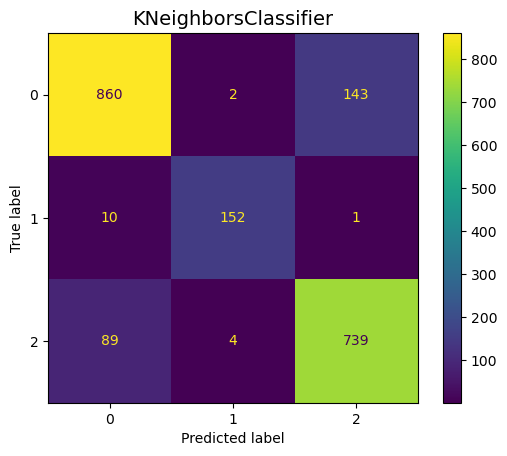

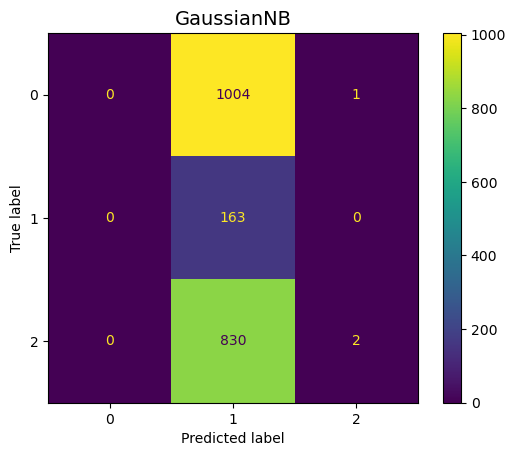

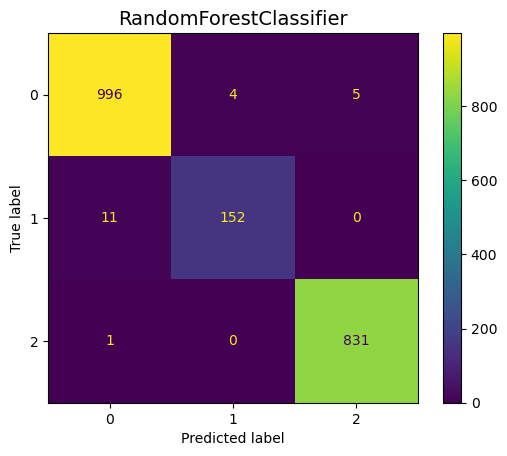

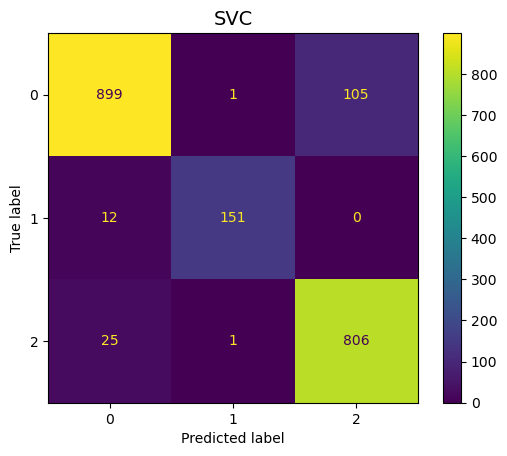

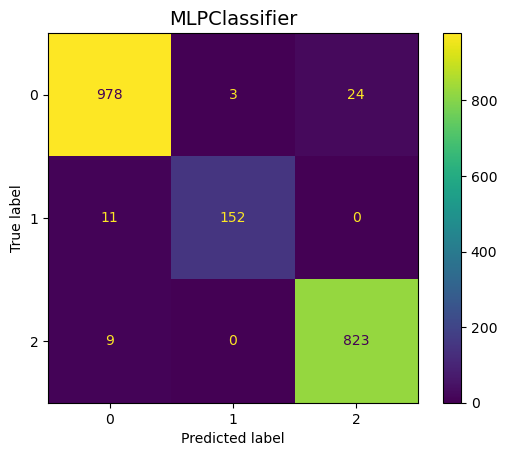

In [27]:
# plot the confusion matrix
for model in [KN, gnb, RandF, svc, mlp]:
    if model == gnb: 
        xtest = sdss[idx_test, :]
        ytest = y[idx_test]
    else: 
        xtest = x[idx_test, :]
        ytest = y[idx_test]
    plot_confusion_matrix(model, xtest, ytest)
    plt.title(str(model.__class__).split(".")[-1].split("'")[0], fontsize = 14)

**Task: Comment on what you see the best classifier is likely to be (1 point).** You can also comment on the misclassification and confusion rates.

* The best classifier will have non zero elements along the main diagonal. These elements on the main diagonal represent the correctly classified data. Those values not on the main diagonal represet false postives, false negative, etc (incorrectly classified data). Therefor we want those values to be as small as possible. At first glance Random Forest and Multi Layer Perceptron seem to be pretty good models. Gaussian Naive Bayes looks peculiar. Values are high along the central column and low elsewhere. Will need to think about this a bit to parse out meaning. 

### 2.4.a K Fold Cross Validation
We will now perform k fold cross valdiation for the classifiers. We use the function ``cross_val_score`` on each ewstimator, on the training set, with 10 folds, and use accuracy as a score metric.

**Task: perform the cross validation over K folds, output the mean and standard deviation of the accuracy (3 points)**

In [28]:
from sklearn.model_selection import cross_val_score
# print("K-nearest neighbors Mean:", scores_knn.mean(),"Standard Deviation:", scores_knn.std())

for model in [KN, gnb, RandF, svc, mlp]: 
    print(f"Working on {model}")
    if model == gnb: 
        xdata = sdss
    else:
        xdata = x
    scores_kn = cross_val_score(model, xdata, y, cv = 10)
    print("Knearest neighbors mean: %.3f Standard Deviation: %.3f" % (scores_kn.mean(), scores_kn.std()))

Working on KNeighborsClassifier()
Knearest neighbors mean: 0.866 Standard Deviation: 0.018
Working on GaussianNB()
Knearest neighbors mean: 0.980 Standard Deviation: 0.006
Working on RandomForestClassifier()
Knearest neighbors mean: 0.989 Standard Deviation: 0.004
Working on SVC()
Knearest neighbors mean: 0.931 Standard Deviation: 0.006
Working on MLPClassifier()
Knearest neighbors mean: 0.979 Standard Deviation: 0.005


**Task: Which method won the Xval test (1 point) ?**

see the cell below

Random Forest was the best performer followed by MLP coming in close second!

<!-- answer here -->





### 2.4.c And the winner is ...

Let's compare the results. 
**Task: Create a pandas dataframe with all of the performance metrics, including the results from K-fold cross validation. (2 points)**

In [32]:
# create data frame
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 'Random Forest', 'SVC','MLP'],
    'Accuracy': [.88,.98,.99,.93,.98],
    'Precision': [.9,.95,.99,.94,.98],
    'Recall': [.89,.97,.97,.93,.96],
    'Fscore': [.89,.96,.98,.94,.97],
    'Kfold_accuracy_mean': [0.866,0.980,0.989,0.931,0.979],
    'Kfold_accuracy_std': [0.018,0.006,0.004,0.006,0.005]})
# sort values by the Fscore with the greatest value first.

In [33]:
results.sort_values("Fscore", ascending=False)

,Model,Accuracy,Precision,Recall,Fscore,Kfold_accuracy_mean,Kfold_accuracy_std
2,Random Forest,0.99,0.99,0.97,0.98,0.989,0.004
4,MLP,0.98,0.98,0.96,0.97,0.979,0.005
1,Naive Bayes,0.98,0.95,0.97,0.96,0.980,0.006
3,SVC,0.93,0.94,0.93,0.94,0.931,0.006
0,KNN,0.88,0.90,0.89,0.89,0.866,0.018


**Task: Comment on the accuracy and performance and choose a winner. (1 point)**

***Random Forest still outperforms all the others in all categories. Akash Wins!!!


see the cell below

<!-- answer here -->






## 3 Summary (4 points)

### 3.1 Feature Importance using Random Forest Classifier

Decision Trees have the unique property of being able to order features by their ability to split between the classes. If some features dominate over other in the predictive power of classes, one can further reduce the dimension of the features for additional analysis. The vector of feature importance is the module ``rfc.feature_importances_``, sorted with ascending importance. Store the vector of importance .

**Task: plot a bar plot using the function ``matplotlib.pyplot.bar``. (2 points)**

Text(0, 0.5, 'Importance')

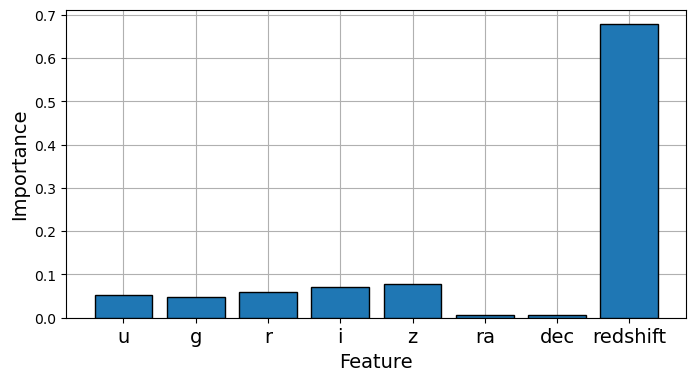

In [35]:
# answer
# vector of importance
# vector of features

plt.figure(figsize = (8,4))
plt.bar(np.arange(8), RandF.feature_importances_, edgecolor = 'k', zorder = 90)
plt.xticks(np.arange(8), ['u', 'g', 'r', 'i', 'z', 'ra', 'dec', 'redshift'], fontsize = 14);
plt.grid(True)
plt.xlabel("Feature", fontsize = 14)
plt.ylabel("Importance", fontsize = 14)

**Task: What are the top three features (1 point)?**

enter in the cell below

Redshift is the strongest feature by far out of all of them. i and z are next in line, but also they are comparable to r and i

<!-- answer -->

In this notebook, you have learned that redshift was the best predictor of what object you are observing. Now, did you actualy need to do this all to find this out? Probably not if you were an astrophysicist! But hey, we are not. So great job!

**Task: Briefly comment on what you have learned (1 point)**

see the cell below

I learned about the importance of testing out different classifiers to see which one is the strongest candidate for your research. Random Forest worked really well here, but MLP may be better suited for someone else research. 

## Bonus questions (5 points)


Perform hyperparameter tuning and ensemble learning to improve on the classification performance.

In [ ]:
# answer below

<!-- answer -->